### Imports

In [1]:
import sys
sys.dont_write_bytecode = True


import torch
import numpy as np
import random
import os

def set_seeds(seed_value=42):
    """Sets seeds for reproducibility."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)

set_seeds(42) 

import json
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import warnings
import logging
from datetime import datetime
warnings.filterwarnings('ignore')

from model import get_model
from config import CFG
from dataset import RMNISTDataset
from plot import plot_domainwise_accuracy
from transform import get_transforms
from runner import run_baseline, run_lodo

torch.manual_seed(CFG["system"]["seed"])
np.random.seed(CFG["system"]["seed"])

device = CFG["system"]["device"]
print(f"Device: {device}")
print(f"PyTorch: {torch.__version__}")


Device: cuda
PyTorch: 2.5.1+cu121


### DataLoading

In [2]:
train_transform, test_transform = get_transforms(img_size=224, augment=False, use_imagenet_norm=False, keep_channels=True)

rmnist = RMNISTDataset(
    data_root=CFG["datasets"]["RMNIST"]["root"],
    transform=train_transform,
    batch_size=CFG["train"]["batch_size"]
)

print("\nData loaders ready!")


Data loaders ready!


### Logging

In [3]:
dataset_name = "RMNIST" 
base_dir = os.path.join(os.getcwd(), dataset_name)
subdirs = ["logs", "checkpoints", "plots"]

for sub in subdirs:
    os.makedirs(os.path.join(base_dir, sub), exist_ok=True)

timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
log_file = os.path.join(base_dir, "logs", f"train_{timestamp}.log")

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s",
    handlers=[
        logging.FileHandler(log_file),
        logging.StreamHandler()
    ]
)

logger = logging.getLogger(f"{dataset_name}_logger")

logger.info(f"Initialized experiment directories for {dataset_name}")
logger.info(f"Logs: {os.path.join(base_dir, 'logs')}")
logger.info(f"Checkpoints: {os.path.join(base_dir, 'checkpoints')}")
logger.info(f"Plots: {os.path.join(base_dir, 'plots')}")

2025-10-10 23:52:42,401 | INFO | Initialized experiment directories for RMNIST
2025-10-10 23:52:42,401 | INFO | Logs: c:\Users\Fatim_Sproj\Desktop\Fatim\Spring 2025\sproj\Visual-Reasoning\Vit-GRQO\resnet\RMNIST\logs
2025-10-10 23:52:42,401 | INFO | Checkpoints: c:\Users\Fatim_Sproj\Desktop\Fatim\Spring 2025\sproj\Visual-Reasoning\Vit-GRQO\resnet\RMNIST\checkpoints
2025-10-10 23:52:42,401 | INFO | Plots: c:\Users\Fatim_Sproj\Desktop\Fatim\Spring 2025\sproj\Visual-Reasoning\Vit-GRQO\resnet\RMNIST\plots


### Setup

In [4]:
domains = CFG["datasets"]["RMNIST"]["domains"]
loaders = {d: {"train": rmnist.get_dataloader(d, train=True), "val": rmnist.get_dataloader(d, train=False)} for d in domains}
ckpt_root = os.path.join(base_dir, "checkpoints")
log_dir = os.path.join(base_dir, "logs")
plots_dir = os.path.join(base_dir, "plots")
os.makedirs(ckpt_root, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)
os.makedirs(plots_dir, exist_ok=True)
model_factory = lambda cfg, dataset_key: get_model(cfg,dataset="RMNIST")
optimizer_fn = lambda model: optim.AdamW(model.parameters(), lr=CFG["train"]["lr"], weight_decay=CFG["train"].get("weight_decay", 0.01))
device = CFG["system"]["device"]
epochs = CFG["train"]["epochs"]

{
  "lodo_results": {
    "art_painting": 0.8341463414634146,
    "cartoon": 0.7974413646055437,
    "photo": 0.9580838323353293,
    "sketch": 0.6017811704834606
  },
  "timestamp": "20251004_020611"
}

### Leave One Domain Out

In [ ]:
lodo_results, lodo_mean, lodo_summary = run_lodo(
    model_fn=model_factory,
    CFG=CFG,
    logger=logger,
    dataset_key="RMNIST",
    domains=domains,
    loaders=loaders,
    optimizer_fn=optimizer_fn,
    device=device,
    ckpt_root=ckpt_root,
    log_dir=log_dir,
    epochs=epochs
)

2025-10-10 20:45:08,259 | INFO | === LODO: Leaving out domain '0' ===



=== LODO: Leaving out domain '0' ===


Evaluating: 100%|██████████| 547/547 [00:28<00:00, 19.15it/s]
2025-10-10 20:50:21,641 | INFO | [0] Epoch 1/5 | Train - Loss: 0.0549, Cls: 0.0540, GRQO: 0.0009, Acc: 0.9841 | Val - Loss: 0.1301, Cls: 0.1301, GRQO: 0.0000, Acc: 0.9603
2025-10-10 20:50:21,692 | INFO | [0] New best val acc: 0.9603


[0] Epoch 1/5 | Train - Loss: 0.0549, Cls: 0.0540, GRQO: 0.0009, Acc: 0.9841 | Val - Loss: 0.1301, Cls: 0.1301, GRQO: 0.0000, Acc: 0.9603
[0] New best val acc: 0.9603


Evaluating: 100%|██████████| 547/547 [00:27<00:00, 19.69it/s]
2025-10-10 20:55:34,723 | INFO | [0] Epoch 2/5 | Train - Loss: 0.0193, Cls: 0.0192, GRQO: 0.0001, Acc: 0.9942 | Val - Loss: 0.0815, Cls: 0.0815, GRQO: 0.0000, Acc: 0.9775
2025-10-10 20:55:34,797 | INFO | [0] New best val acc: 0.9775


[0] Epoch 2/5 | Train - Loss: 0.0193, Cls: 0.0192, GRQO: 0.0001, Acc: 0.9942 | Val - Loss: 0.0815, Cls: 0.0815, GRQO: 0.0000, Acc: 0.9775
[0] New best val acc: 0.9775


Evaluating: 100%|██████████| 547/547 [00:27<00:00, 19.63it/s]
2025-10-10 21:00:48,658 | INFO | [0] Epoch 3/5 | Train - Loss: 0.0141, Cls: 0.0141, GRQO: 0.0000, Acc: 0.9957 | Val - Loss: 0.1099, Cls: 0.1099, GRQO: 0.0000, Acc: 0.9701


[0] Epoch 3/5 | Train - Loss: 0.0141, Cls: 0.0141, GRQO: 0.0000, Acc: 0.9957 | Val - Loss: 0.1099, Cls: 0.1099, GRQO: 0.0000, Acc: 0.9701


Evaluating: 100%|██████████| 547/547 [00:27<00:00, 19.94it/s]
2025-10-10 21:06:02,470 | INFO | [0] Epoch 4/5 | Train - Loss: 0.0111, Cls: 0.0111, GRQO: 0.0000, Acc: 0.9966 | Val - Loss: 0.1952, Cls: 0.1952, GRQO: 0.0000, Acc: 0.9517


[0] Epoch 4/5 | Train - Loss: 0.0111, Cls: 0.0111, GRQO: 0.0000, Acc: 0.9966 | Val - Loss: 0.1952, Cls: 0.1952, GRQO: 0.0000, Acc: 0.9517


Evaluating: 100%|██████████| 547/547 [00:27<00:00, 19.64it/s]
2025-10-10 21:11:17,051 | INFO | [0] Epoch 5/5 | Train - Loss: 0.0092, Cls: 0.0092, GRQO: 0.0000, Acc: 0.9973 | Val - Loss: 0.1358, Cls: 0.1358, GRQO: 0.0000, Acc: 0.9647
2025-10-10 21:11:17,051 | INFO | [0] Best Acc: 0.9775
2025-10-10 21:11:17,051 | INFO | ------------------------------------------------------------
2025-10-10 21:11:17,168 | INFO | === LODO: Leaving out domain '15' ===


[0] Epoch 5/5 | Train - Loss: 0.0092, Cls: 0.0092, GRQO: 0.0000, Acc: 0.9973 | Val - Loss: 0.1358, Cls: 0.1358, GRQO: 0.0000, Acc: 0.9647
[0] Best Acc: 0.9775
------------------------------------------------------------

=== LODO: Leaving out domain '15' ===


Evaluating: 100%|██████████| 547/547 [00:27<00:00, 19.61it/s]
2025-10-10 21:16:32,898 | INFO | [15] Epoch 1/5 | Train - Loss: 0.0545, Cls: 0.0536, GRQO: 0.0009, Acc: 0.9844 | Val - Loss: 0.0438, Cls: 0.0438, GRQO: 0.0000, Acc: 0.9865
2025-10-10 21:16:32,950 | INFO | [15] New best val acc: 0.9865


[15] Epoch 1/5 | Train - Loss: 0.0545, Cls: 0.0536, GRQO: 0.0009, Acc: 0.9844 | Val - Loss: 0.0438, Cls: 0.0438, GRQO: 0.0000, Acc: 0.9865
[15] New best val acc: 0.9865


Evaluating: 100%|██████████| 547/547 [00:27<00:00, 19.99it/s]
2025-10-10 21:21:47,715 | INFO | [15] Epoch 2/5 | Train - Loss: 0.0200, Cls: 0.0199, GRQO: 0.0001, Acc: 0.9939 | Val - Loss: 0.0371, Cls: 0.0371, GRQO: 0.0000, Acc: 0.9884
2025-10-10 21:21:47,802 | INFO | [15] New best val acc: 0.9884


[15] Epoch 2/5 | Train - Loss: 0.0200, Cls: 0.0199, GRQO: 0.0001, Acc: 0.9939 | Val - Loss: 0.0371, Cls: 0.0371, GRQO: 0.0000, Acc: 0.9884
[15] New best val acc: 0.9884


Evaluating: 100%|██████████| 547/547 [00:27<00:00, 19.59it/s]
2025-10-10 21:27:02,461 | INFO | [15] Epoch 3/5 | Train - Loss: 0.0147, Cls: 0.0147, GRQO: 0.0000, Acc: 0.9956 | Val - Loss: 0.0271, Cls: 0.0271, GRQO: 0.0000, Acc: 0.9915
2025-10-10 21:27:02,530 | INFO | [15] New best val acc: 0.9915


[15] Epoch 3/5 | Train - Loss: 0.0147, Cls: 0.0147, GRQO: 0.0000, Acc: 0.9956 | Val - Loss: 0.0271, Cls: 0.0271, GRQO: 0.0000, Acc: 0.9915
[15] New best val acc: 0.9915


Evaluating: 100%|██████████| 547/547 [00:27<00:00, 19.61it/s]
2025-10-10 21:32:16,843 | INFO | [15] Epoch 4/5 | Train - Loss: 0.0118, Cls: 0.0118, GRQO: 0.0000, Acc: 0.9964 | Val - Loss: 0.0424, Cls: 0.0424, GRQO: 0.0000, Acc: 0.9871


[15] Epoch 4/5 | Train - Loss: 0.0118, Cls: 0.0118, GRQO: 0.0000, Acc: 0.9964 | Val - Loss: 0.0424, Cls: 0.0424, GRQO: 0.0000, Acc: 0.9871


Evaluating: 100%|██████████| 547/547 [00:27<00:00, 19.75it/s]
2025-10-10 21:37:30,308 | INFO | [15] Epoch 5/5 | Train - Loss: 0.0096, Cls: 0.0096, GRQO: 0.0000, Acc: 0.9971 | Val - Loss: 0.0367, Cls: 0.0367, GRQO: -0.0000, Acc: 0.9890
2025-10-10 21:37:30,308 | INFO | [15] Best Acc: 0.9915
2025-10-10 21:37:30,308 | INFO | ------------------------------------------------------------
2025-10-10 21:37:30,436 | INFO | === LODO: Leaving out domain '30' ===


[15] Epoch 5/5 | Train - Loss: 0.0096, Cls: 0.0096, GRQO: 0.0000, Acc: 0.9971 | Val - Loss: 0.0367, Cls: 0.0367, GRQO: -0.0000, Acc: 0.9890
[15] Best Acc: 0.9915
------------------------------------------------------------

=== LODO: Leaving out domain '30' ===


Evaluating: 100%|██████████| 547/547 [00:27<00:00, 19.56it/s]
2025-10-10 21:42:45,572 | INFO | [30] Epoch 1/5 | Train - Loss: 0.0558, Cls: 0.0548, GRQO: 0.0009, Acc: 0.9841 | Val - Loss: 0.0293, Cls: 0.0293, GRQO: 0.0000, Acc: 0.9906
2025-10-10 21:42:45,646 | INFO | [30] New best val acc: 0.9906


[30] Epoch 1/5 | Train - Loss: 0.0558, Cls: 0.0548, GRQO: 0.0009, Acc: 0.9841 | Val - Loss: 0.0293, Cls: 0.0293, GRQO: 0.0000, Acc: 0.9906
[30] New best val acc: 0.9906


Evaluating: 100%|██████████| 547/547 [00:27<00:00, 19.63it/s]
2025-10-10 21:48:00,338 | INFO | [30] Epoch 2/5 | Train - Loss: 0.0204, Cls: 0.0204, GRQO: 0.0001, Acc: 0.9936 | Val - Loss: 0.0477, Cls: 0.0477, GRQO: 0.0000, Acc: 0.9838


[30] Epoch 2/5 | Train - Loss: 0.0204, Cls: 0.0204, GRQO: 0.0001, Acc: 0.9936 | Val - Loss: 0.0477, Cls: 0.0477, GRQO: 0.0000, Acc: 0.9838


Evaluating: 100%|██████████| 547/547 [00:27<00:00, 19.65it/s]
2025-10-10 21:53:14,678 | INFO | [30] Epoch 3/5 | Train - Loss: 0.0145, Cls: 0.0145, GRQO: 0.0000, Acc: 0.9955 | Val - Loss: 0.0202, Cls: 0.0202, GRQO: 0.0000, Acc: 0.9942
2025-10-10 21:53:14,753 | INFO | [30] New best val acc: 0.9942


[30] Epoch 3/5 | Train - Loss: 0.0145, Cls: 0.0145, GRQO: 0.0000, Acc: 0.9955 | Val - Loss: 0.0202, Cls: 0.0202, GRQO: 0.0000, Acc: 0.9942
[30] New best val acc: 0.9942


### Baseline

In [5]:
model_name ="resnet18"
baseline_results, baseline_mean = run_baseline(
    model_name=model_name,
    CFG=CFG,
    logger=logger,
    dataset_key="RMNIST",
    domains=domains,
    loaders=loaders,
    optimizer_fn=optimizer_fn,
    device=device,
    epochs=CFG["train"]["epochs"]
)


2025-10-10 23:53:00,750 | INFO | Initializing ResNet baseline: resnet18
2025-10-10 23:53:00,901 | INFO | === Baseline LODO: Leaving out domain '0' ===


Initializing ResNet baseline: resnet18

=== Baseline LODO: Leaving out domain '0' ===


2025-10-10 23:57:23,704 | INFO | [0] Epoch 1/5 | Train - Loss: 0.0425, Acc: 0.9875 | Val Acc: 0.9643


[0] Epoch 1/5 | Train - Loss: 0.0425, Acc: 0.9875 | Val Acc: 0.9643


2025-10-11 00:02:48,819 | INFO | [0] Epoch 2/5 | Train - Loss: 0.0153, Acc: 0.9953 | Val Acc: 0.9725


[0] Epoch 2/5 | Train - Loss: 0.0153, Acc: 0.9953 | Val Acc: 0.9725


2025-10-11 00:07:29,331 | INFO | [0] Epoch 3/5 | Train - Loss: 0.0107, Acc: 0.9966 | Val Acc: 0.9752


[0] Epoch 3/5 | Train - Loss: 0.0107, Acc: 0.9966 | Val Acc: 0.9752


2025-10-11 00:11:54,412 | INFO | [0] Epoch 4/5 | Train - Loss: 0.0081, Acc: 0.9974 | Val Acc: 0.9817


[0] Epoch 4/5 | Train - Loss: 0.0081, Acc: 0.9974 | Val Acc: 0.9817


2025-10-11 00:16:32,579 | INFO | [0] Epoch 5/5 | Train - Loss: 0.0059, Acc: 0.9981 | Val Acc: 0.9844
2025-10-11 00:16:32,579 | INFO | [0] Best Val Acc: 0.9844
2025-10-11 00:16:32,579 | INFO | ------------------------------------------------------------
2025-10-11 00:16:32,579 | INFO | Initializing ResNet baseline: resnet18
2025-10-11 00:16:32,662 | INFO | === Baseline LODO: Leaving out domain '15' ===


[0] Epoch 5/5 | Train - Loss: 0.0059, Acc: 0.9981 | Val Acc: 0.9844
[0] Best Val Acc: 0.9844
------------------------------------------------------------
Initializing ResNet baseline: resnet18

=== Baseline LODO: Leaving out domain '15' ===


2025-10-11 00:20:52,509 | INFO | [15] Epoch 1/5 | Train - Loss: 0.0424, Acc: 0.9878 | Val Acc: 0.9872


[15] Epoch 1/5 | Train - Loss: 0.0424, Acc: 0.9878 | Val Acc: 0.9872


2025-10-11 00:25:11,819 | INFO | [15] Epoch 2/5 | Train - Loss: 0.0160, Acc: 0.9950 | Val Acc: 0.9887


[15] Epoch 2/5 | Train - Loss: 0.0160, Acc: 0.9950 | Val Acc: 0.9887


2025-10-11 00:29:38,826 | INFO | [15] Epoch 3/5 | Train - Loss: 0.0114, Acc: 0.9963 | Val Acc: 0.9860


[15] Epoch 3/5 | Train - Loss: 0.0114, Acc: 0.9963 | Val Acc: 0.9860


2025-10-11 00:34:55,883 | INFO | [15] Epoch 4/5 | Train - Loss: 0.0085, Acc: 0.9973 | Val Acc: 0.9916


[15] Epoch 4/5 | Train - Loss: 0.0085, Acc: 0.9973 | Val Acc: 0.9916


2025-10-11 00:40:09,654 | INFO | [15] Epoch 5/5 | Train - Loss: 0.0068, Acc: 0.9978 | Val Acc: 0.9898
2025-10-11 00:40:09,654 | INFO | [15] Best Val Acc: 0.9916
2025-10-11 00:40:09,654 | INFO | ------------------------------------------------------------
2025-10-11 00:40:09,654 | INFO | Initializing ResNet baseline: resnet18
2025-10-11 00:40:09,741 | INFO | === Baseline LODO: Leaving out domain '30' ===


[15] Epoch 5/5 | Train - Loss: 0.0068, Acc: 0.9978 | Val Acc: 0.9898
[15] Best Val Acc: 0.9916
------------------------------------------------------------
Initializing ResNet baseline: resnet18

=== Baseline LODO: Leaving out domain '30' ===


2025-10-11 00:44:45,148 | INFO | [30] Epoch 1/5 | Train - Loss: 0.0424, Acc: 0.9879 | Val Acc: 0.9899


[30] Epoch 1/5 | Train - Loss: 0.0424, Acc: 0.9879 | Val Acc: 0.9899


2025-10-11 00:49:44,914 | INFO | [30] Epoch 2/5 | Train - Loss: 0.0161, Acc: 0.9950 | Val Acc: 0.9949


[30] Epoch 2/5 | Train - Loss: 0.0161, Acc: 0.9950 | Val Acc: 0.9949


2025-10-11 00:54:10,116 | INFO | [30] Epoch 3/5 | Train - Loss: 0.0111, Acc: 0.9965 | Val Acc: 0.9839


[30] Epoch 3/5 | Train - Loss: 0.0111, Acc: 0.9965 | Val Acc: 0.9839


2025-10-11 00:58:29,179 | INFO | [30] Epoch 4/5 | Train - Loss: 0.0086, Acc: 0.9972 | Val Acc: 0.9938


[30] Epoch 4/5 | Train - Loss: 0.0086, Acc: 0.9972 | Val Acc: 0.9938


2025-10-11 01:02:46,761 | INFO | [30] Epoch 5/5 | Train - Loss: 0.0064, Acc: 0.9979 | Val Acc: 0.9924
2025-10-11 01:02:46,761 | INFO | [30] Best Val Acc: 0.9949
2025-10-11 01:02:46,762 | INFO | ------------------------------------------------------------
2025-10-11 01:02:46,762 | INFO | Initializing ResNet baseline: resnet18
2025-10-11 01:02:46,836 | INFO | === Baseline LODO: Leaving out domain '45' ===


[30] Epoch 5/5 | Train - Loss: 0.0064, Acc: 0.9979 | Val Acc: 0.9924
[30] Best Val Acc: 0.9949
------------------------------------------------------------
Initializing ResNet baseline: resnet18

=== Baseline LODO: Leaving out domain '45' ===


2025-10-11 01:07:17,696 | INFO | [45] Epoch 1/5 | Train - Loss: 0.0431, Acc: 0.9876 | Val Acc: 0.9893


[45] Epoch 1/5 | Train - Loss: 0.0431, Acc: 0.9876 | Val Acc: 0.9893


2025-10-11 01:11:44,928 | INFO | [45] Epoch 2/5 | Train - Loss: 0.0160, Acc: 0.9950 | Val Acc: 0.9924


[45] Epoch 2/5 | Train - Loss: 0.0160, Acc: 0.9950 | Val Acc: 0.9924


2025-10-11 01:16:12,054 | INFO | [45] Epoch 3/5 | Train - Loss: 0.0113, Acc: 0.9963 | Val Acc: 0.9941


[45] Epoch 3/5 | Train - Loss: 0.0113, Acc: 0.9963 | Val Acc: 0.9941


2025-10-11 01:20:37,208 | INFO | [45] Epoch 4/5 | Train - Loss: 0.0082, Acc: 0.9973 | Val Acc: 0.9902


[45] Epoch 4/5 | Train - Loss: 0.0082, Acc: 0.9973 | Val Acc: 0.9902


2025-10-11 01:25:20,723 | INFO | [45] Epoch 5/5 | Train - Loss: 0.0064, Acc: 0.9979 | Val Acc: 0.9951
2025-10-11 01:25:20,723 | INFO | [45] Best Val Acc: 0.9951
2025-10-11 01:25:20,723 | INFO | ------------------------------------------------------------
2025-10-11 01:25:20,723 | INFO | Initializing ResNet baseline: resnet18
2025-10-11 01:25:20,823 | INFO | === Baseline LODO: Leaving out domain '60' ===


[45] Epoch 5/5 | Train - Loss: 0.0064, Acc: 0.9979 | Val Acc: 0.9951
[45] Best Val Acc: 0.9951
------------------------------------------------------------
Initializing ResNet baseline: resnet18

=== Baseline LODO: Leaving out domain '60' ===


2025-10-11 01:29:47,470 | INFO | [60] Epoch 1/5 | Train - Loss: 0.0434, Acc: 0.9874 | Val Acc: 0.9910


[60] Epoch 1/5 | Train - Loss: 0.0434, Acc: 0.9874 | Val Acc: 0.9910


KeyboardInterrupt: 

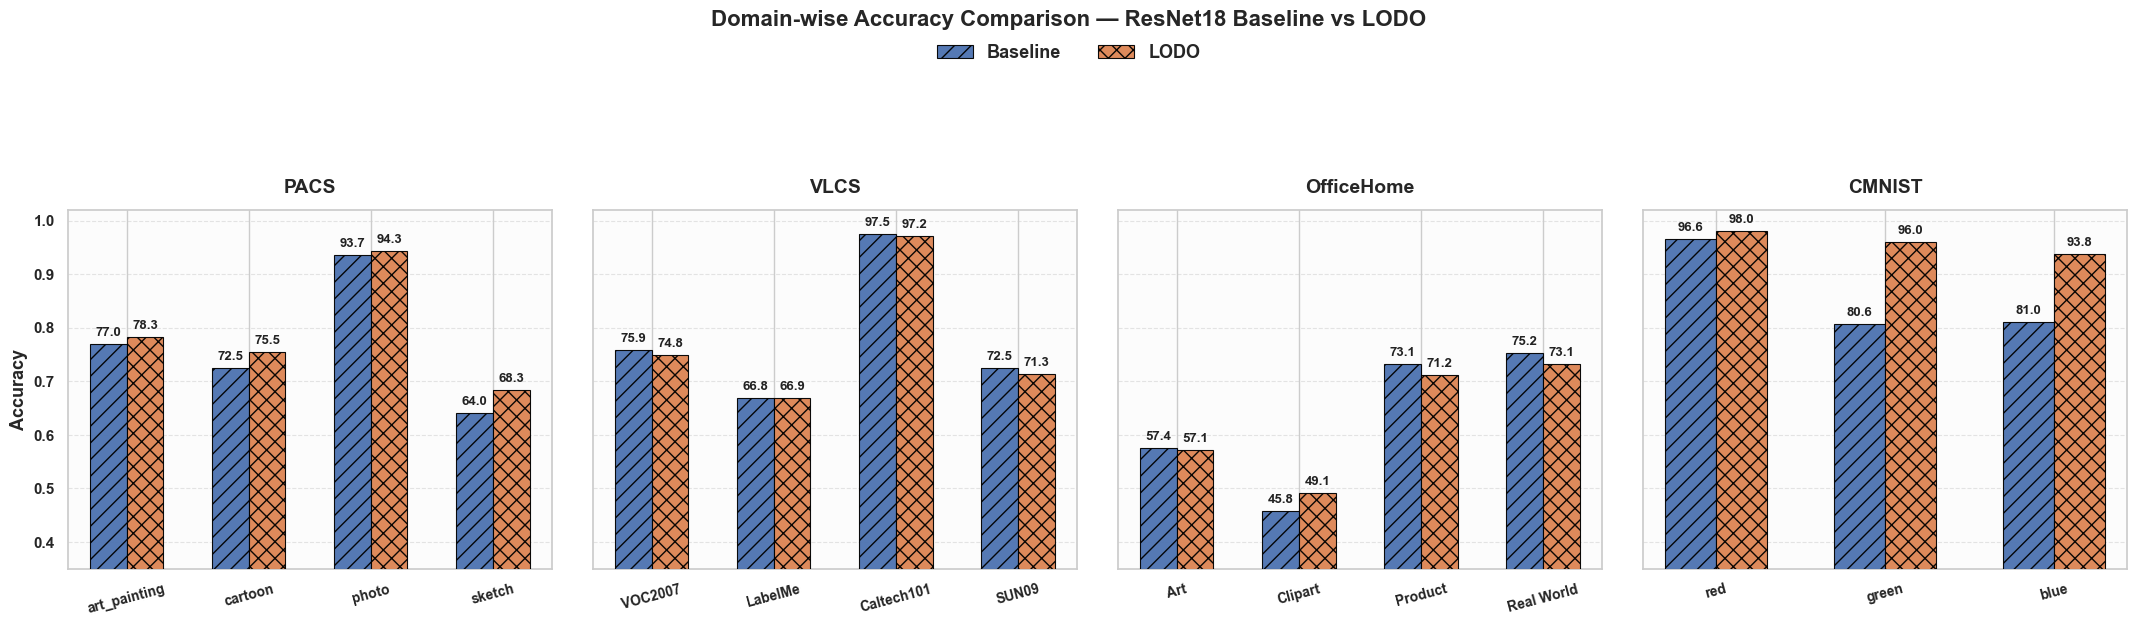

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# --- Data (unchanged) ---
pacs_data = {
    "lodo_results": {"art_painting": 0.7831207065750736, "cartoon": 0.7546928327645052, "photo": 0.9431137724550899, "sketch": 0.6833799949096462},
    "baseline_results": {"art_painting": 0.7699, "cartoon": 0.7253, "photo": 0.9365, "sketch": 0.6399}
}
vlcs_data = {
  "lodo_results": {"VOC2007": 0.7482227488151659, "LabelMe": 0.6686746987951807, "Caltech101": 0.9717314487632509, "SUN09": 0.7126751980499695},
  "baseline_results": {"VOC2007": 0.7586, "LabelMe": 0.6679, "Caltech101": 0.9753, "SUN09": 0.7252}
}
officehome_data = {
  "lodo_results": {"Art": 0.5714874330449115, "Clipart": 0.49095074455899196, "Product": 0.7120973192160397, "Real World": 0.7314666054624742},
  "baseline_results": {"Art": 0.5744, "Clipart": 0.4584, "Product": 0.7312, "Real World": 0.7519}
}
cmnist_data = {
  "lodo_results": {"red": 0.9801366597807087, "green": 0.9595687331536388, "blue": 0.9376102646351243},
  "baseline_results": {"red": 0.9660, "green": 0.8059, "blue": 0.8096}
}

datasets = {
    "PACS": pacs_data,
    "VLCS": vlcs_data,
    "OfficeHome": officehome_data,
    "CMNIST": cmnist_data
}

# --- Refined Style ---
sns.set_theme(style="whitegrid")
plt.rcParams.update({
    "axes.labelweight": "bold",
    "axes.titleweight": "bold",
    "axes.titlesize": 14,
    "axes.labelsize": 13,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 12,
    "font.family": "sans-serif",
    "font.weight": "bold",
})

# --- Modern pastel color pair ---
palette_base = "#4C72B0"   # Deep blue
palette_lodo = "#DD8452"   # Warm orange
hatch_base = "//"
hatch_lodo = "xx"

# --- Plot ---
fig, axes = plt.subplots(1, 4, figsize=(22, 6), sharey=True)
ymin, ymax = 0.35, 1.02

for ax, (dataset_name, data) in zip(axes, datasets.items()):
    domains = list(data["lodo_results"].keys())
    baseline_vals = [data["baseline_results"][d] for d in domains]
    lodo_vals = [data["lodo_results"][d] for d in domains]

    x = np.arange(len(domains))
    width = 0.30  # slightly thinner bars

    # Bars with subtle outline
    bars1 = ax.bar(x - width/2, baseline_vals, width, label="Baseline",
                   color=palette_base, edgecolor='black', hatch=hatch_base, linewidth=0.8, alpha=0.95, zorder=3)
    bars2 = ax.bar(x + width/2, lodo_vals, width, label="LODO",
                   color=palette_lodo, edgecolor='black', hatch=hatch_lodo, linewidth=0.8, alpha=0.95, zorder=3)

    # Text labels above bars (clean placement)
    for bar in bars1 + bars2:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, h + 0.01,
                f"{h*100:.1f}", ha="center", va="bottom",
                fontsize=9.5, weight='bold', color="#222", rotation=0)

    # Axis & title formatting
    ax.set_title(dataset_name, pad=12)
    ax.set_xticks(x)
    ax.set_xticklabels(domains, fontsize=10, rotation=15, weight="bold")
    ax.set_ylim(ymin, ymax)
    ax.set_facecolor("#FCFCFC")
    ax.grid(axis='y', linestyle='--', alpha=0.5, linewidth=0.8, zorder=0)
    ax.set_axisbelow(True)

# Shared labels & legend
axes[0].set_ylabel("Accuracy", fontsize=13, weight="bold")
fig.legend(["Baseline", "LODO"],
           loc="upper center", ncol=2, frameon=False,
           fontsize=13, bbox_to_anchor=(0.5, 1.05))

# Global title
fig.suptitle("Domain-wise Accuracy Comparison — ResNet18 Baseline vs LODO",
             fontsize=16, weight="bold", y=1.08)

plt.tight_layout(pad=2.5, rect=[0, 0, 1, 0.97])
plt.show()
